In [1]:
import numpy as np
import math

REWARDS = np.array([-50,-5,20,10]) # all pareto optimal
THREATS = np.array([-20,-30,-100,-40])

# REWARDS = np.array([-50,2.5,20,-70]) # A,B,C pareto optimal
# THREATS = np.array([-2,-8,-10,-8])*10

# REWARDS = np.array([-50,-5,20,-70]) # A,C pareto optimal
# THREATS = np.array([-2,-9,-10,-8])

# REWARDS = np.array([-25,-25,25,25])
# THREATS = np.array([25,25,-25,-25])
refpoint = np.array([0,0])
max_reward = np.max(REWARDS)
max_threat = np.max(THREATS)

p = 0.04
W = int(1/p)+1
tau = np.array([0.1, 0.5,  1,  4, 16, 32, 64, 256,1024])
N_tau = np.size(tau)
epsilon = np.arange(11)*0.1
epsilon = np.around(epsilon, decimals = 2)
N_eps = np.size(epsilon)

def probabilities_one(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            weight = [w*p, 1.0-w*p]
            temp = (weight[0]*R + weight[1]*T)/tau[n]
            P[w,n,:] = np.exp(temp)/np.sum(np.exp(temp))
    learner = "Softmax"
    return np.round(P,3), learner

def probabilities_two(R,T):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        ex_R = np.exp((R - np.max(R))/tau[n])
        ex_T = np.exp((T - np.max(T))/tau[n])
        weight_R = ex_R/np.sum(ex_R)
        weight_T = ex_T/np.sum(ex_T)
        for w in range(W):
            weight = [w*p,1.0-w*p]
            P[w,n,:] = weight[0]*weight_R + weight[1]*weight_T
    learner = "Softmax Two"
    return np.round(P,3), learner



def hypervolume(R,T, refpoint):
    P = np.zeros((W,N_tau,4))
    for n in range(N_tau):
        for w in range(W):
            temp = np.zeros(4)
            for i in range(4):
                temp[i] = pow(abs(R[i] - np.min(R) +refpoint[0]), w*p/tau[n])*pow(abs(T[i] - np.min(T)+refpoint[1]), (1-w*p)/tau[n])
            #print(temp)
            P[w,n,:] = temp/np.sum(temp)
    learner = "Hypervolume"
    return P, learner

def eps_greedy(R,T,eps):
    P = np.zeros((W,N_eps,4))
    temp = np.zeros(4)
    for n in range(N_eps):
        for w in range(W):
            weight = [w*p, 1-w*p]
            for i in range(4):
                temp[i] = weight[0]*R[i] + weight[1]*T[i]
            k = np.argmax(temp)
            for i in range(4):
                if i == k:
                    P[w,n,i] = 1-0.75*eps[n]
                else:
                    P[w,n,i] = 0.25*eps[n]
    
    learner = "Epsilon-Greedy"
    return P, learner
        
reward_regret = np.zeros((W,N_tau))
threat_regret = np.zeros((W,N_tau))
prob, learner_type = probabilities_one(REWARDS,THREATS)
for w in range(W):
    for n in range(N_tau):
        reward_regret[w,n] = max_reward - np.dot(prob[w,n], REWARDS)
        threat_regret[w,n] = max_threat - np.dot(prob[w,n], THREATS)



thr_regret = max_threat -THREATS
print("pure threat regret ", thr_regret)
rew_regret = max_reward - REWARDS
print("pure reward regrets", rew_regret)
print(REWARDS)

pure threat regret  [ 0 10 80 20]
pure reward regrets [70 25  0 10]
[-50  -5  20  10]


In [2]:
# Pareto front plotter
# Decides if (a,b) is strictly dominated by (a1,b1)
def isPareto(a,b,a1,b1):
    if a==a1:
        if b > b1:
            return True
        else:
            return False
    elif a < a1:
        return False
    elif b>=b1:
        return True
    else:
        return False
     
front_x = []
front_y = []
for i in range(4):
    count = 0
    for j in range(4):
        if isPareto(thr_regret[i], rew_regret[i], thr_regret[j],rew_regret[j]):
            count+=1
            print(thr_regret[i], rew_regret[i], " dominates ", thr_regret[j], rew_regret[j])
    print("i = ",i , " ", count)
    print("-----------------------")
    if count == 1:
        front_x.append(thr_regret[i])
        front_y.append(rew_regret[i])

i =  0   0
-----------------------
i =  1   0
-----------------------
i =  2   0
-----------------------
i =  3   0
-----------------------


0
0
0
0


Text(0.5, 1.0, 'Pareto Front for SGT ')

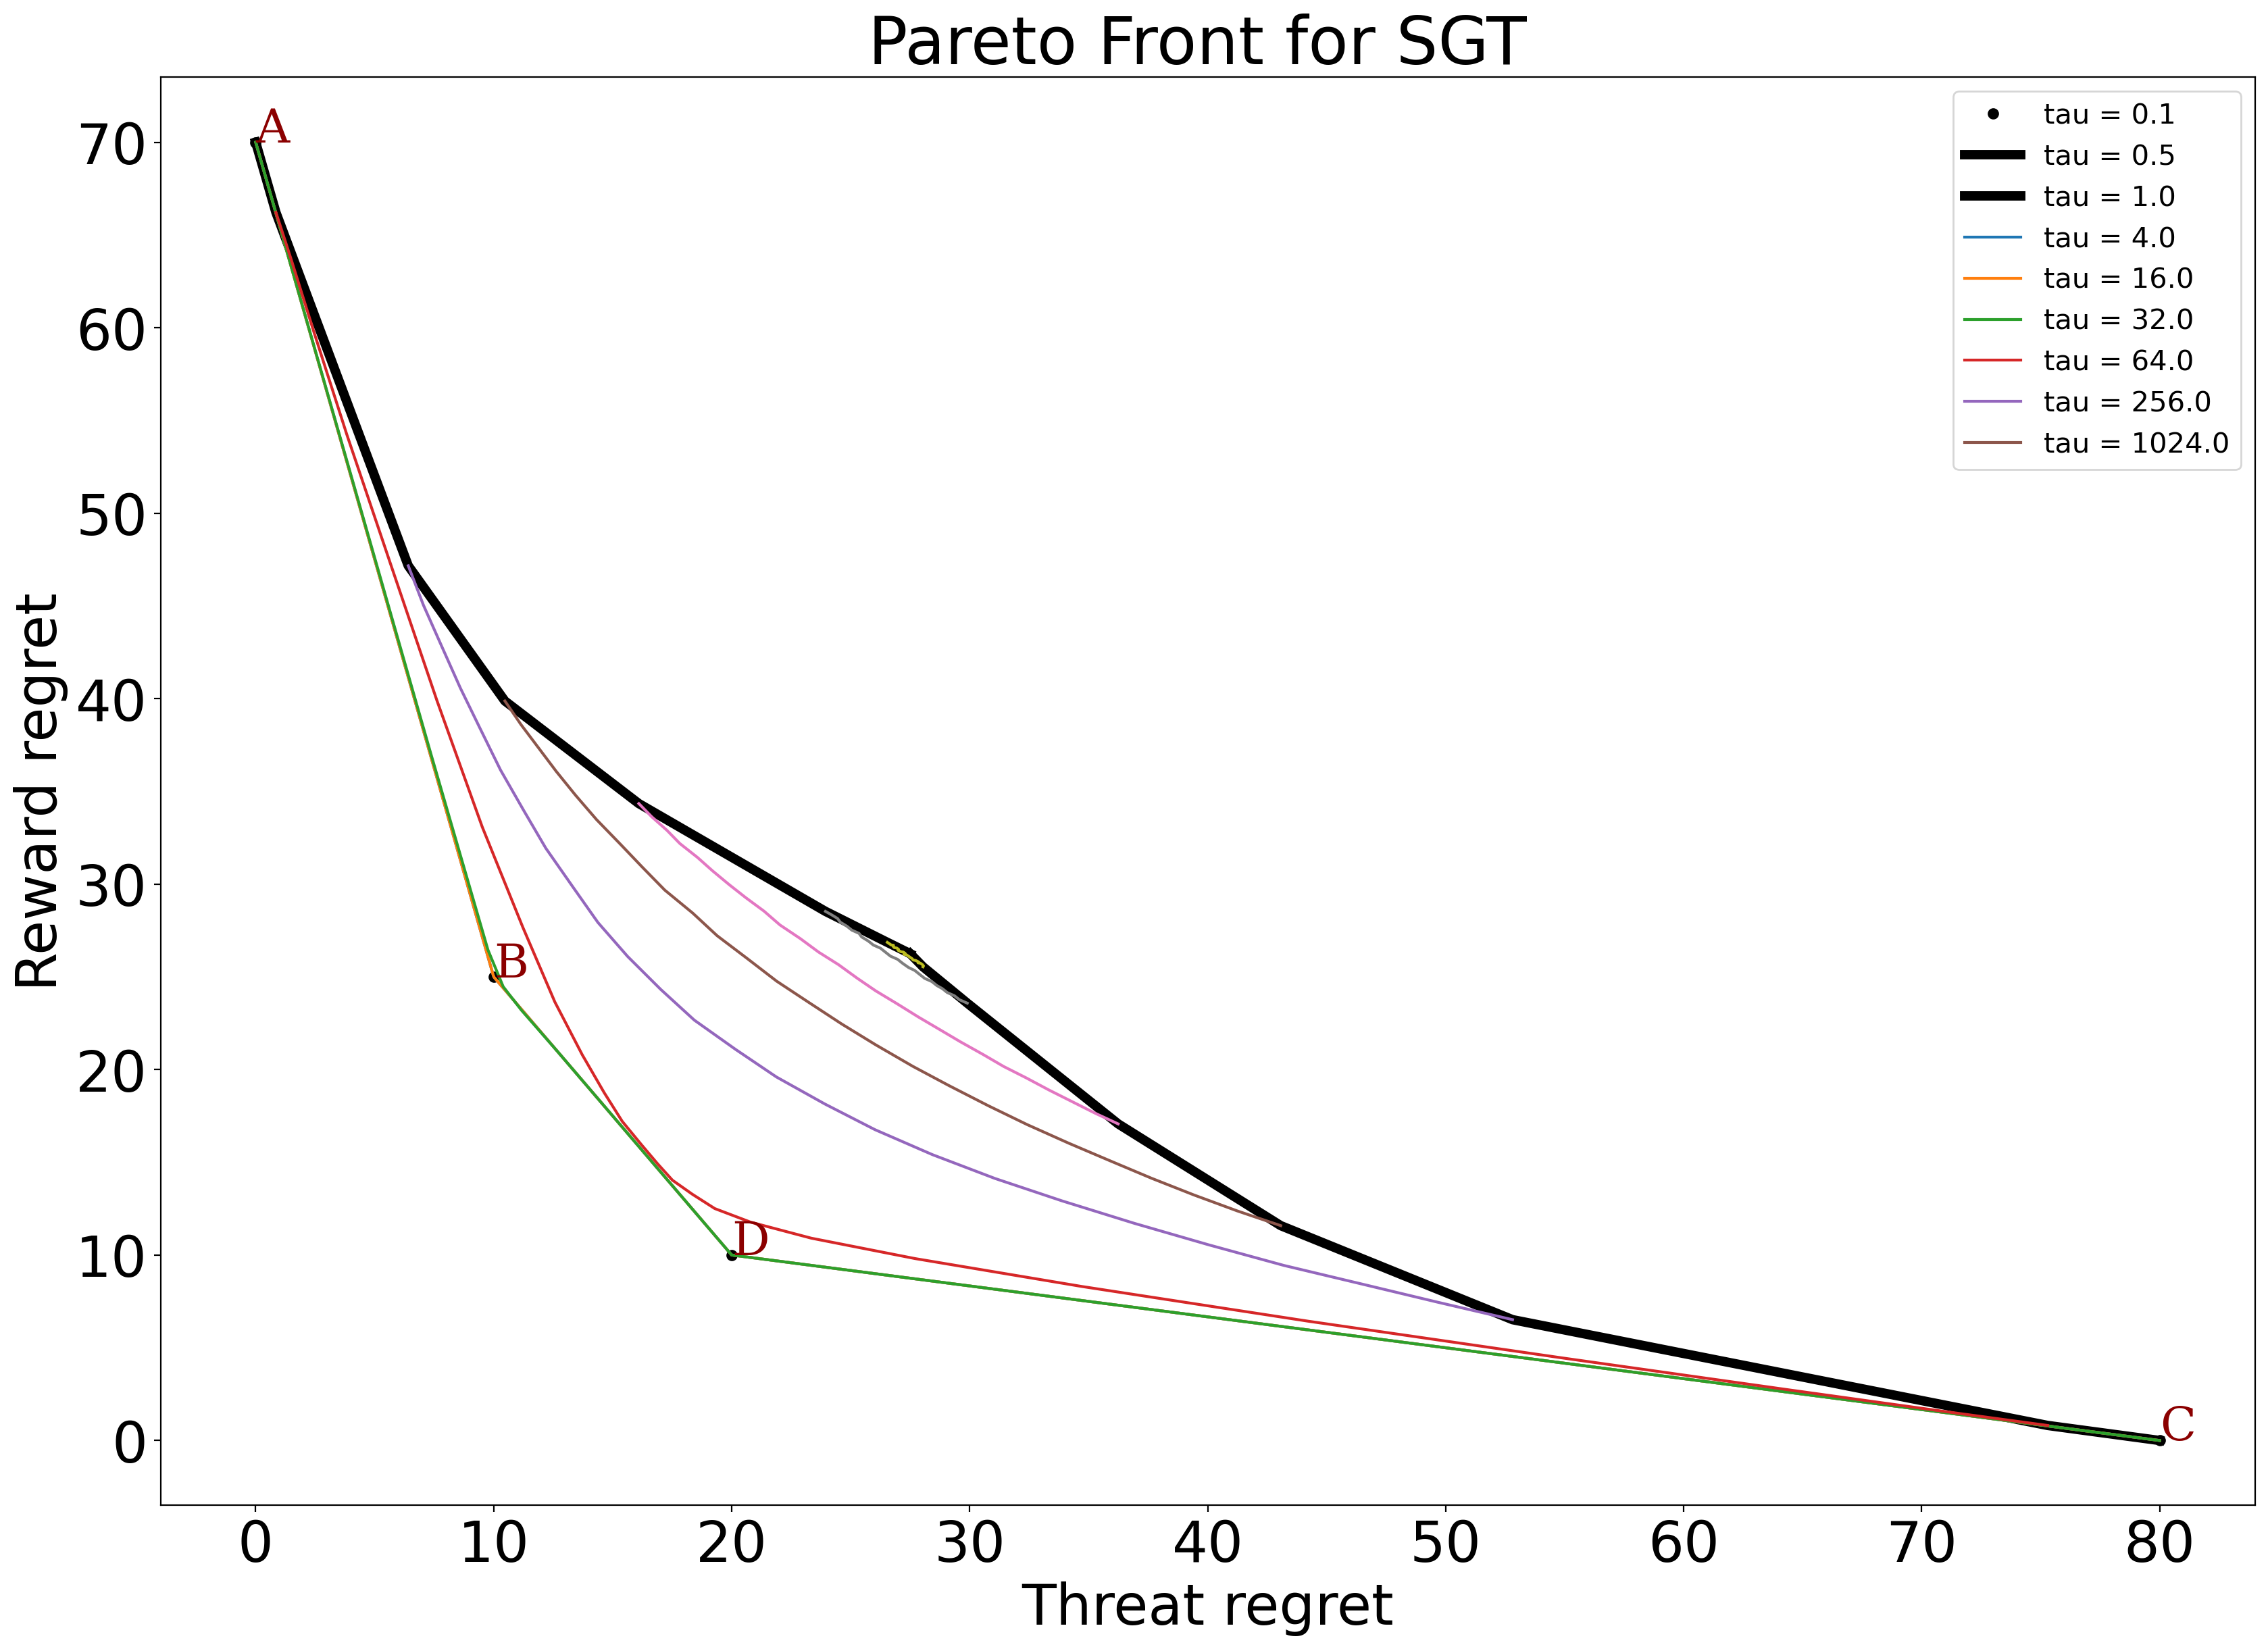

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig_one = figure(figsize=(20, 14), dpi=200)



#----------------------Plotting The Boundary of Feasible Region-------------------------------
plt.plot(thr_regret,rew_regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
# first plot the Pareto Front between A,B,C,D
front_x = []
front_y = []
for i in range(4):
    count = 0
    for j in range(4):
        if isPareto(thr_regret[i], rew_regret[i], thr_regret[j],rew_regret[j]):
            count+=1
    print(count)
    if count == 0:
        front_x.append(thr_regret[i])
        front_y.append(rew_regret[i])
sorted_pareto = []
for i in range(len(front_x)):
    sorted_pareto.append([front_x[i], front_y[i]])
sorted_pareto.sort()


front = np.array(sorted_pareto)


#plt.plot(front[:,0], front[:,1], color = "red", linewidth = 5)

thr_regret = np.round(thr_regret, 2)
rew_regret = np.round(rew_regret, 2)

centroid_x = np.mean(thr_regret)
centroid_y = np.mean(rew_regret)

zero_x = threat_regret[0,:]
zero_y = reward_regret[0,:]
one_x = threat_regret[W-1,:]
one_y = reward_regret[W-1,:]

zero_x = np.append(zero_x, centroid_x)
zero_y = np.append(zero_y, centroid_y)
one_x = np.append(one_x, centroid_x)
one_y = np.append(one_y, centroid_y)


plt.plot(zero_x, zero_y, color = 'black', linewidth = 5)
plt.legend('asdsa')
plt.plot(one_x, one_y, color = 'black', linewidth = 5)
lbls = ['A ', 'B', 'C', 'D']
#lbls_SGT = ['A,B', 'A,B','C,D', 'C,D']
font = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 25,
    }
for i in range(4):
    plt.text(thr_regret[i], rew_regret[i], lbls[i], fontdict = font )

#plt.text(centroid_x, centroid_y,'Centroid', fontdict = font)
#------------------------------------Plotting The Interior of Feasible Region---------------------------------------------
lgd = []
for n in range(N_tau):
    lgd.append("tau = "+str(tau[n]))


for n in range(N_tau):
    
    y = reward_regret[:,n]
    x = threat_regret[:,n]
    #plt.scatter(x, y)
    plt.plot(x,y)
    plt.legend(lgd, fontsize = 15)
#print(max_threat, max_reward)
#plt.plot(max_threat, max_reward,'o')   
plt.xlabel("Threat regret", fontsize = 30)
plt.ylabel("Reward regret", fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.title("Pareto Front for SGT " , fontsize=35)



In [4]:
print(threat_regret[0,:])
print(zero_x)
print(reward_regret[0,:])
print(zero_y)


print(rew_regret)
print(thr_regret)

[ 0.    0.    0.    0.85  6.41 10.47 16.1  23.94 26.54]
[ 0.    0.    0.    0.85  6.41 10.47 16.1  23.94 26.54 27.5 ]
[70.    70.    70.    66.215 47.165 39.875 34.34  28.53  26.86 ]
[70.    70.    70.    66.215 47.165 39.875 34.34  28.53  26.86  26.25 ]
[70 25  0 10]
[ 0 10 80 20]


0
0
0
0


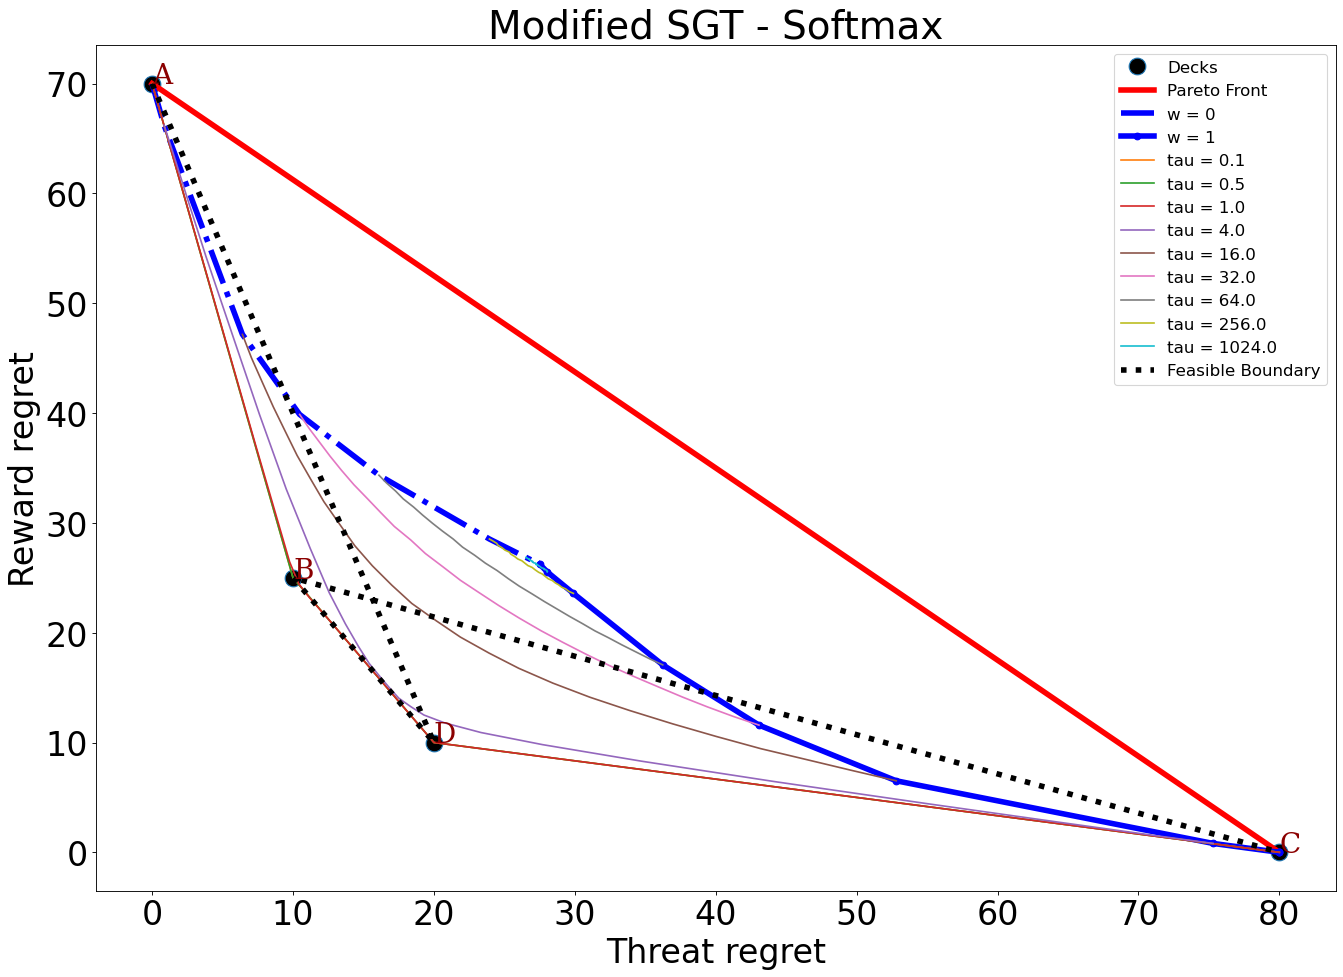

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fig_one = figure(figsize=(20, 14), dpi=80)



#----------------------Plotting The Boundary of Feasible Region-------------------------------
plt.plot(thr_regret,rew_regret,"s", marker = "o", markersize = 15, markerfacecolor = "black")
# first plot the Pareto Front between A,B,C,D
front_x = []
front_y = []
for i in range(4):
    count = 0
    for j in range(4):
        if isPareto(thr_regret[i], rew_regret[i], thr_regret[j],rew_regret[j]):
            count+=1
    print(count)
    if count == 0:
        front_x.append(thr_regret[i])
        front_y.append(rew_regret[i])
sorted_pareto = []
for i in range(len(front_x)):
    sorted_pareto.append([front_x[i], front_y[i]])
sorted_pareto.sort()


front = np.array(sorted_pareto)


#plt.plot(front[:,0], front[:,1], color = "red", linewidth = 5, label = "Pareto Front")
plt.plot([thr_regret[0], thr_regret[2]], [rew_regret[0], rew_regret[2]], color = 'red', linewidth = 5)


centroid_x = np.mean(thr_regret)
centroid_y = np.mean(rew_regret)

zero_x = threat_regret[0,:]
zero_y = reward_regret[0,:]
one_x = threat_regret[W-1,:]
one_y = reward_regret[W-1,:]

zero_x = np.append(zero_x, centroid_x)
zero_y = np.append(zero_y, centroid_y)
one_x = np.append(one_x, centroid_x)
one_y = np.append(one_y, centroid_y)


plt.plot(zero_x, zero_y,'-.', color = 'blue', linewidth = 5)
plt.plot(one_x, one_y,'-o', color = 'blue', linewidth = 5)
lbls = ['A ', 'B', 'C', 'D']
font = {'family': 'serif',
    'color':  'darkred',
    'weight': 'normal',
    'size': 25,
    }
for i in range(4):
    plt.text(thr_regret[i], rew_regret[i], lbls[i], fontdict = font )

#plt.text(centroid_x, centroid_y,'Centroid', fontdict = font)
#------------------------------------Plotting The Interior of Feasible Region---------------------------------------------
lgd = ['Decks', 'Pareto Front', 'w = 0', 'w = 1']
for n in range(N_tau):
    lgd.append("tau = "+str(tau[n]))

for n in range(N_tau):
    
    y = reward_regret[:,n]
    x = threat_regret[:,n]
    plt.plot(x, y)
    #plt.text(x[-3], y[-3], tau[n], fontsize = 20)

plt.xlabel("Threat regret")
plt.ylabel("Reward regret")
#plt.title("Pareto front of Threat-Reward Regret Pairs by Explicitly Solving for the Q-values for "+learner_type , fontsize=15)

plt.xlabel("Threat regret", fontsize = 30)
plt.ylabel("Reward regret", fontsize = 30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.title("Modified SGT - Softmax" , fontsize=35)
#plt.plot([thr_regret[0], thr_regret[2]], [rew_regret[0], rew_regret[2]],':', color = 'black', linewidth = 5)
plt.plot([thr_regret[0], thr_regret[3], thr_regret[1], thr_regret[2]], [rew_regret[0], rew_regret[3], rew_regret[1], rew_regret[2]],':', color = 'black', linewidth = 5)
lgd.append('Feasible Boundary')
plt.legend(lgd, fontsize = 15) 
# making shaded region
# xx = np.append(zero_x, one_x)
# yy = np.append(zero_y, one_y)

# plt.fill(xx,yy , 0, color='orange', alpha=0.2) 



<Figure size 1600x1120 with 0 Axes>

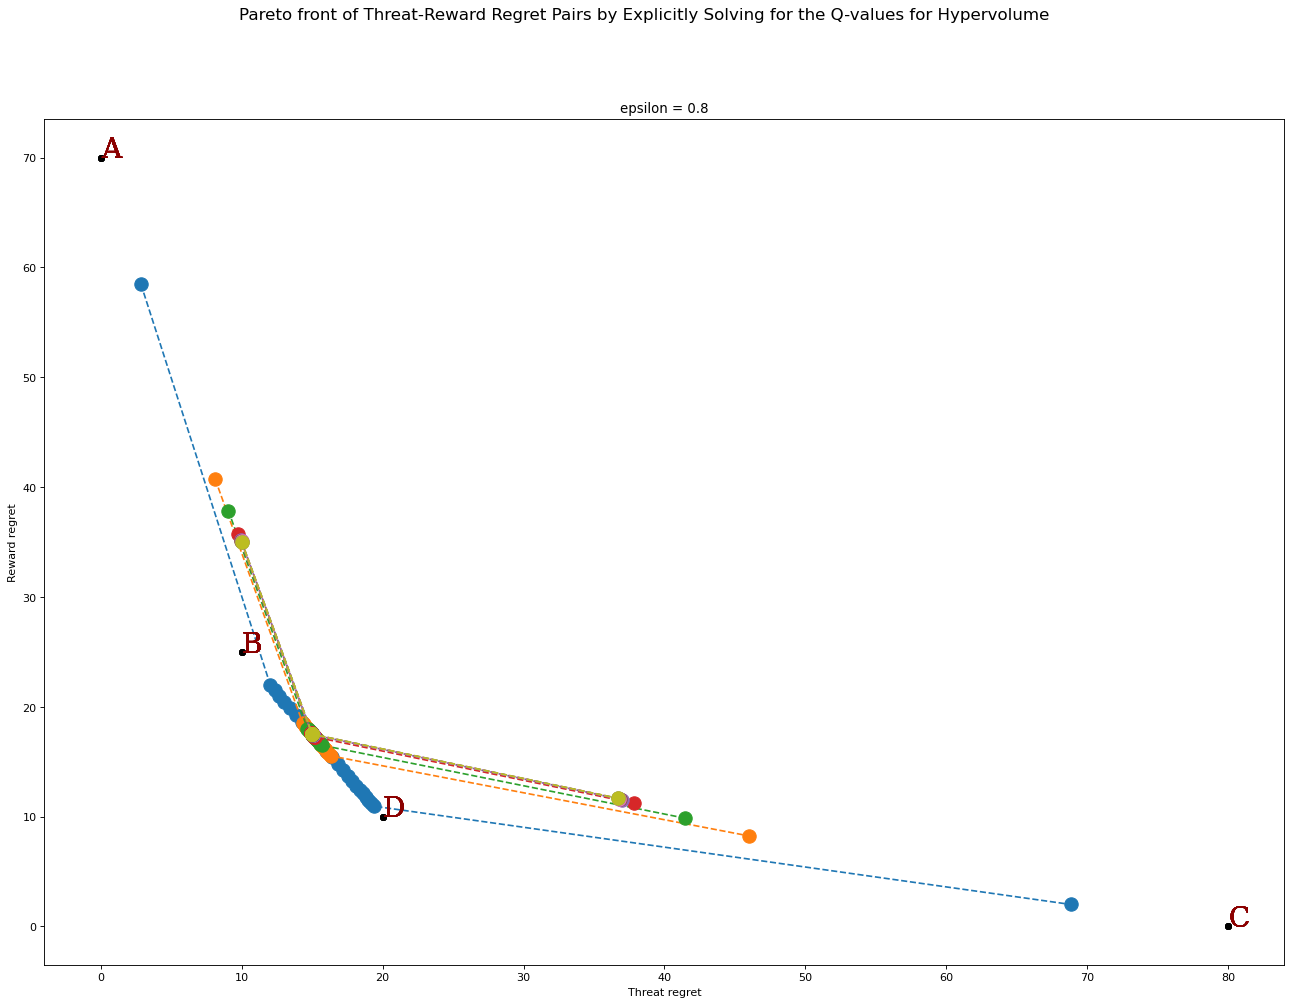

In [6]:
# plotting for epsilon-greedy - there is no tau here.
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20, 14), dpi=80)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20, 14), dpi=80)

   

    

reward_regret = np.zeros((W,N_eps))
threat_regret = np.zeros((W,N_eps))
prob, learner_type = hypervolume(REWARDS, THREATS, refpoint)
for w in range(W):
    for n in range(N_tau):
        reward_regret[w,n] = max_reward - np.dot(prob[w,n], REWARDS)
        threat_regret[w,n] = max_threat - np.dot(prob[w,n], THREATS)

for n in range(N_tau):
    plt.plot(thr_regret,rew_regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
    thr_regret = np.round(thr_regret, 2)
    regret = np.round(rew_regret, 2)
    lbls = ['A ', 'B', 'C', 'D']
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 25,
            }
    for i in range(4):
        plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )
    y = reward_regret[:,n]
    x = threat_regret[:,n]
    #plt.subplot(3,4,n+1)
    plt.plot(x, y,'--o', markersize = 12)
    #print(x, y)
    plt.title("epsilon = "+str(epsilon[n]))
    plt.xlabel("Threat regret")
    plt.ylabel("Reward regret")
plt.suptitle("Pareto front of Threat-Reward Regret Pairs by Explicitly Solving for the Q-values for "+learner_type , fontsize=15) 
plt.show()